In [1]:
######################################### NOTES ###############################################
# * Subset Selection
#   * Total subset selection finds the best score among k pedictors between a model
#     with 0 predictors (the intercept) up to a model with k predictors. Computationally
#     expensive.
#   * Forward stepwise selection finds the best scoring model from 0 to k, but it keeps
#     all predictors from previous steps. Less expensive, but may hot have the best test error
#     compared to the best model in total subset selection
#   * Backward stepwise is the same as forward except you start at k predictors and remove
#     the worst one from k to 0.
#
################################################################################################

In [2]:
# Import packages

import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [4]:
# Configure SQL

def execute_statement(sql: str):
    with psycopg2.connect(host="localhost", database="thefantasybot", user="tbakely") as conn:
         df = pd.read_sql(sql, conn)
         return df

weekly_sql = """
select
	wd.player_id,
	wd.player_name,
	position,
	recent_team,
	wd.season,
	wd.week,
	carries,
	rushing_yards,
	rushing_tds,
	rushing_fumbles,
	rushing_fumbles_lost,
	rushing_first_downs,
	rushing_epa,
	--efficiency,
	--percent_attempts_gte_eight_defenders,
	--avg_time_to_los,
	--rush_yards_over_expected,
	--avg_rush_yards,
	--rush_yards_over_expected_per_att,
	--rush_pct_over_expected,
	wd.receptions,
	wd.targets,
	receiving_yards,
	receiving_tds,
	receiving_fumbles,
	receiving_fumbles_lost,
	receiving_air_yards,
	receiving_yards_after_catch,
	receiving_first_downs,
	receiving_epa,
	racr,
	target_share,
	air_yards_share,
	wopr,
	offense_snaps,
	offense_pct,
    redzone.redzone,
	(carries + wd.targets) as total_usage,
    wd.fantasy_points,
    wd.fantasy_points_ppr,
	roof,
	surface,
	weather_hazards,
	temp,
	humidity,
	wind_speed
from archive_data.weekly_data wd
left join archive_data.offense_snap_counts os
on wd.player_id = os.id
and wd.season = os.season
and wd.week = os.week
left join archive_data.ngs_rushing_data ngsr
on wd.player_id = ngsr.player_gsis_id
and wd.season = ngsr.season
and wd.week = ngsr.week
left join archive_data.ngs_receiving_data ngsrr
on wd.player_id = ngsrr.player_gsis_id
and wd.season = ngsrr.season
and wd.week = ngsrr.week
left join (select distinct rusher_player_id, game_id, season, week from archive_data.full_pbp) game_id
on wd.player_id = game_id.rusher_player_id
and wd.season = game_id.season
and wd.week = game_id.week
left join archive_data.game_data
on game_data.game_id = game_id.game_id
left join archive_data.redzone_snaps redzone
on wd.player_id = redzone.player_id
and wd.season = redzone.season
and wd.week = redzone.week
where position in ('WR', 'RB', 'TE')
and wd.season between 2016 and 2022;
"""

# Load weekly data from 2016-2022; Modify above query as needed
weekly = execute_statement(weekly_sql)

# Dealing with null values
weekly1 = weekly.copy()
weekly1.dropna(subset=["player_name"], inplace=True)
weekly1.dropna(subset=["offense_snaps"], inplace=True)

fill_na_cols = [
    "rushing_epa",
    "receiving_epa",
    "racr",
    "target_share",
    "air_yards_share",
    "wopr",
    "redzone",
]

weather_cols = [
    "roof",
    "surface",
    "weather_hazards",
    "temp",
    "humidity",
    "wind_speed",
]

for col in fill_na_cols:
    weekly1[col] = weekly[col].fillna(0)

weekly1 = weekly1[[col for col in weekly1.columns if col not in weather_cols]]
weekly1["week"] = weekly1["week"].astype(str)
weekly1["season"] = weekly1["season"].astype(str)

weekly1["scored"] = np.where((weekly1["receiving_tds"] > 0) | (weekly1["rushing_tds"] > 0), 1, 0)
weekly1["multi_score"] = np.where(weekly1["receiving_tds"] + weekly1["rushing_tds"] > 1, 1, 0)
weekly1["total_yards"] = weekly1["rushing_yards"] + weekly1["receiving_yards"]
weekly1["total_epa"] = weekly1["rushing_epa"] + weekly1["receiving_epa"]
weekly1["total_first_downs"] = weekly1["rushing_first_downs"] + weekly1["receiving_first_downs"]


try_columns = ["total_epa", "total_first_downs", "target_share", "redzone", "offense_pct", "total_usage"]


model_data = weekly1.select_dtypes(include="number")
model_data.head()

,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share,wopr,offense_snaps,offense_pct,redzone,total_usage,fantasy_points,fantasy_points_ppr,scored,multi_score,total_yards,total_epa,total_first_downs
14,0,0.0,0,0.0,0.0,0.0,0.0,3,4,20.0,0,0.0,0.0,19.0,9.0,0.0,-0.258469,1.052632,0.111111,0.087156,0.227676,48.0,0.66,0.0,4,2.0,5.0,0,0,20.0,-0.258469,0.0
15,0,0.0,0,0.0,0.0,0.0,0.0,3,5,15.0,1,0.0,0.0,25.0,8.0,2.0,0.662646,0.600000,0.200000,0.122549,0.385784,36.0,0.53,3.0,5,7.5,10.5,1,0,15.0,0.662646,2.0
16,0,0.0,0,0.0,0.0,0.0,0.0,4,5,30.0,1,1.0,1.0,36.0,6.0,2.0,-0.809390,0.833333,0.166667,0.076596,0.303617,18.0,0.35,1.0,5,7.0,11.0,1,0,30.0,-0.809390,2.0
17,0,0.0,0,0.0,0.0,0.0,0.0,2,6,16.0,0,0.0,0.0,52.0,4.0,2.0,-0.385813,0.307692,0.206897,0.256158,0.489655,31.0,0.47,0.0,6,1.6,3.6,0,0,16.0,-0.385813,2.0
18,0,0.0,0,0.0,0.0,0.0,0.0,5,10,38.0,0,0.0,0.0,77.0,13.0,3.0,1.970081,0.493507,0.227273,0.198454,0.479827,38.0,0.51,3.0,10,3.8,8.8,0,0,38.0,1.970081,3.0


In [53]:
# import additional
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from functools import partial
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# new modules
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [6]:
# Cp scoring
# what is this again??

def nCp(sigma2, estimator, X, Y):
    """Negative Cp statistic"""
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [10]:
# Model set up

def model_data_setup(df: pd.DataFrame, response_var: str):
    X = df.drop(response_var, axis=1).values
    y = df[[response_var]].values
    return (X, y)

X, y = model_data_setup(model_data, "fantasy_points_ppr")

In [27]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# Manually without Standard Scaler
Xs = X - X.mean(0)[None, :]
X_scale = X.std(0)
Xs = Xs / X_scale[None, :]
lambdas = 10**np.linspace(8, -2, 100) / y.std()

# Preprocessing method
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Elastic Net
# * This combines the lasso and ridge techniques by using a l1
# parameter and l2 parameter (lamda1 and lambda2).
# * We extract the array of coefficients corresponding to the solutions
# along the regularization path.
# * When l1_ratio is 0, we're doing ridge regression
soln_array = ElasticNet.path(Xs, y, l1_ratio=0, alphas=lambdas)[1]
soln_array.shape

(1, 31, 100)

In [40]:
soln_array[0].shape
lambdas.shape

(100,)

In [43]:
soln_path = pd.DataFrame(soln_array[0].T, columns=model_data.drop("fantasy_points_ppr", axis=1).columns, index=-np.log(lambdas))
soln_path.index.name = "negative log(lambda)"
soln_path

,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share,wopr,offense_snaps,offense_pct,redzone,total_usage,fantasy_points,scored,multi_score,total_yards,total_epa,total_first_downs
negative log(lambda),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-16.381546,2.010972e-07,2.319351e-07,2.412087e-07,3.537902e-08,1.522653e-08,2.302749e-07,9.895270e-08,4.464942e-07,3.906877e-07,4.472481e-07,3.538347e-07,3.661637e-08,1.775233e-08,2.513969e-07,3.953391e-07,4.231541e-07,3.200313e-07,6.887644e-09,3.750282e-07,2.288009e-07,3.345627e-07,2.986953e-07,2.870884e-07,3.022034e-07,3.937976e-07,5.714827e-07,4.038348e-07,2.975744e-07,5.298033e-07,3.267243e-07,5.055640e-07
-16.148961,2.537559e-07,2.926689e-07,3.043709e-07,4.464325e-08,1.921370e-08,2.905739e-07,1.248641e-07,5.634117e-07,4.929918e-07,5.643629e-07,4.464887e-07,4.620460e-08,2.240089e-08,3.172268e-07,4.988613e-07,5.339598e-07,4.038336e-07,8.691219e-09,4.732318e-07,2.887139e-07,4.221701e-07,3.769106e-07,3.622644e-07,3.813374e-07,4.969161e-07,7.211293e-07,5.095816e-07,3.754962e-07,6.685358e-07,4.122793e-07,6.379493e-07
-15.916377,3.202035e-07,3.693062e-07,3.840724e-07,5.633338e-08,2.424493e-08,3.666626e-07,1.575606e-07,7.109447e-07,6.220849e-07,7.121451e-07,5.634047e-07,5.830357e-08,2.826671e-08,4.002947e-07,6.294914e-07,6.737806e-07,5.095801e-07,1.096707e-08,5.971506e-07,3.643155e-07,5.327181e-07,4.756071e-07,4.571257e-07,4.811931e-07,6.270369e-07,9.099618e-07,6.430189e-07,4.738224e-07,8.435963e-07,5.202373e-07,8.050005e-07
-15.683793,4.040509e-07,4.660114e-07,4.846443e-07,7.108463e-08,3.059362e-08,4.626755e-07,1.988189e-07,8.971102e-07,7.849819e-07,8.986248e-07,7.109359e-07,7.357073e-08,3.566852e-08,5.051144e-07,7.943278e-07,8.502144e-07,6.430169e-07,1.383887e-08,7.535183e-07,4.597138e-07,6.722137e-07,6.001479e-07,5.768270e-07,6.071967e-07,7.912306e-07,1.148241e-06,8.113976e-07,5.978959e-07,1.064497e-06,6.564648e-07,1.015795e-06
-15.451208,5.098543e-07,5.880395e-07,6.115515e-07,8.969860e-08,3.860475e-08,5.838301e-07,2.508809e-07,1.132024e-06,9.905343e-07,1.133935e-06,8.970991e-07,9.283569e-08,4.500854e-08,6.373818e-07,1.002328e-06,1.072848e-06,8.113950e-07,1.746266e-08,9.508318e-07,5.800927e-07,8.482371e-07,7.573003e-07,7.278727e-07,7.661950e-07,9.984193e-07,1.448915e-06,1.023867e-06,7.544588e-07,1.343243e-06,8.283643e-07,1.281787e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.713968,-1.266181e-02,3.708276e-01,5.778526e-01,1.087145e-03,-6.968993e-02,-9.618270e-04,8.124009e-03,2.247613e+00,6.273216e-02,4.986687e-01,7.497806e-01,-1.456422e-04,-7.698331e-02,-2.950840e-02,-6.742735e-04,8.176594e-03,1.029009e-02,3.162089e-04,9.919823e-03,-7.643001e-03,2.695742e-03,3.281012e-03,-4.984569e-03,-1.610754e-03,3.985816e-02,4.094501e+00,1.101861e-01,5.822449e-02,6.926422e-01,9.612818e-03,6.361649e-03
5.946552,-1.822379e-02,3.281862e-01,5.208126e-01,1.100988e-03,-6.194231e-02,4.188230e-03,7.602414e-03,2.265778e+00,4.775682e-02,4.378053e-01,6.761038e-01,-1.567622e-04,-6.814800e-02,-2.521183e-02,-1.387277e-03,1.195964e-02,1.150465e-02,2.176003e-04,8.182355e-03,-6.204093e-03,2.238476e-03,3.206575e-03,-4.642411e-03,-1.426188e-03,3.867394e-02,4.338371e+00,8.117458e-02,4.306692e-02,6.114004e-01,3.500366e-03,-2.327630e-03
6.179136,-2.250882e-02,2.877098e-01,4.619701e-01,1.062154e-03,-5.427359e-02,9.486495e-03,7.730226e-03,2.280809e+00,3.513097e-02,3.811050e-01,5.999827e-01,-1.572167e-04,-5.951169e-02,-2.128874e-02,-1.714521e-03,1.638622e-02,1.337656e-02,1.466530e-04,6.761235e-03,-5.039389e-03,1.854780e-03,3.038252e-03,-4.233912e-03,-1.245663e-03,3.798334e-02,4.571482e+00,5.858981e-02,3.124717e-02,5.309932e-01,-2.325507e-03,-1.084242e-02


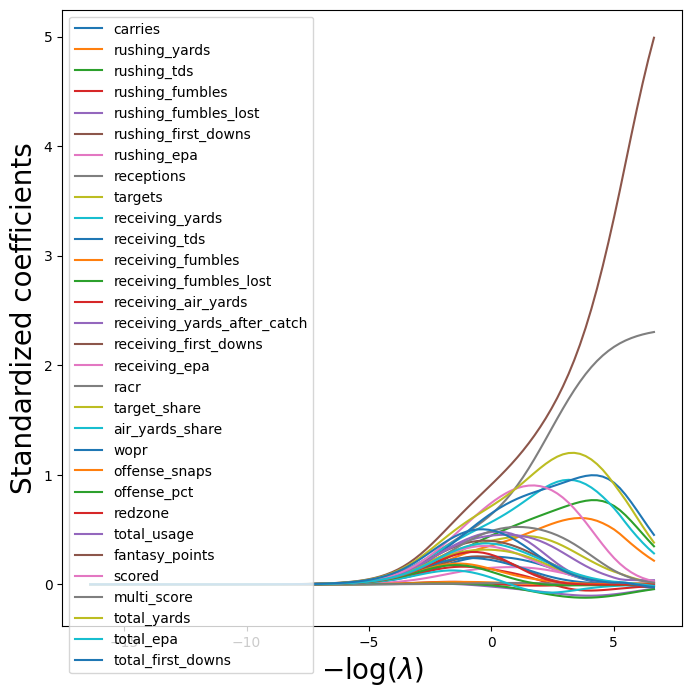

In [44]:
# The results on this are obviously meaningless because we included
# fantasy points as a predictor, but this is good demonstration of the
# regularization.

path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Standardized coefficients", fontsize=20)
ax.legend(loc="upper left")
plt.show()

In [45]:
# Pipeline fitting the ridge model
ridge = ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[("scaler", scaler), ("ridge", ridge)])
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=14.282985834958339, l1_ratio=0))])

In [46]:
np.linalg.norm(ridge.coef_)

0.975767841031741

In [52]:
# Estimating Test Error
ridge.alpha = 0.01
results = cross_validate(ridge, X, y, scoring="neg_mean_squared_error", cv=10)
-np.mean(results["test_score"])

0.0003208491049903615

In [54]:
# Now apply a grid search
param_grid = dict(ridge__alpha = lambdas)
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(X, y)
grid.best_params_["ridge__alpha"]
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.0013014124738939124, l1_ratio=0))])

In [ ]:
# So far we seem to always need the model to fit, StandardScaler,
# a cross validation method, and a grid search for tuning hyperparameters

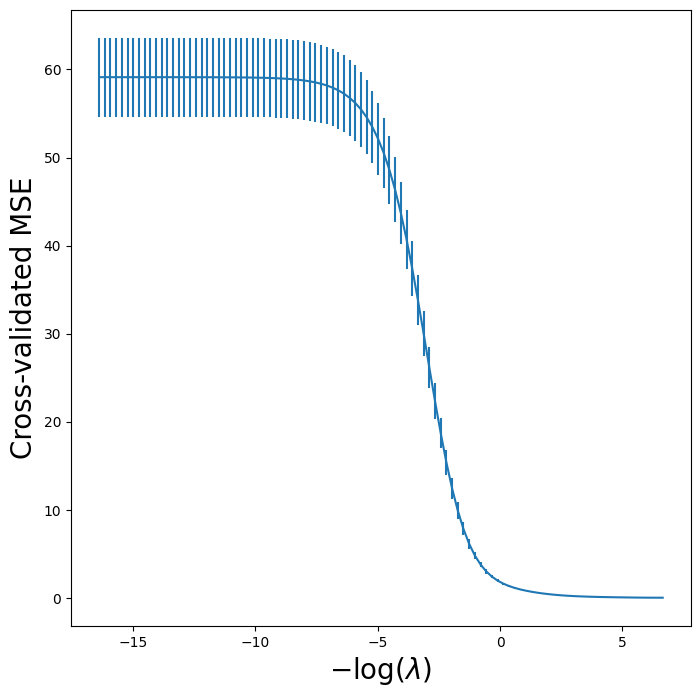

In [56]:
ridge_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas), 
            -grid.cv_results_["mean_test_score"], 
            yerr=grid.cv_results_["std_test_score"]
            )
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-validated MSE", fontsize=20)
plt.show()

In [58]:
grid.best_params_

{'ridge__alpha': 0.0013014124738939124}

In [59]:
from sklearn.model_selection import ShuffleSplit

# Validation set creation
outer_valid = ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)

# Train/test set creation


In [64]:
# Is this the reason why we want to split into 3 parts? So that
# we can cross validate on the "training/test" sets and then test
# on the validation set?

[12368  3664 29792 ... 12172   235 29733]


In [70]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Lasso

# Lasso
lassoCV = ElasticNetCV(n_alphas=100,
                       l1_ratio=1,
                       cv=5)

pipeCV = Pipeline([("scaler", scaler), ("lasso", lassoCV)])
pipeCV.fit(X, y)
tuned_lasso = pipeCV.named_steps["lasso"]
tuned_lasso.alpha_

0.007437353038363754

In [105]:
lambdas, soln_array = Lasso.path(Xs, y, l1_ratio=1, n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array[0].T, columns=model_data.drop("fantasy_points_ppr", axis=1).columns, index=np.log(lambdas))

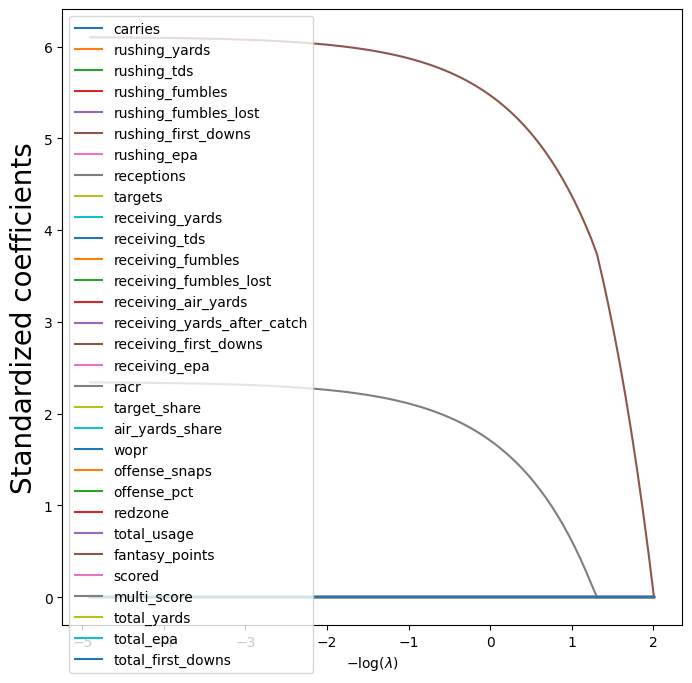

In [106]:
path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc="upper left")
ax.set_xlabel("$-\log(\lambda)$")
ax.set_ylabel("Standardized coefficients", fontsize=20)
plt.show()

In [97]:
np.min(tuned_lasso.mse_path_.mean(1))

6.971668050945625e-05

Text(0, 0.5, 'Cross-validated MSE')

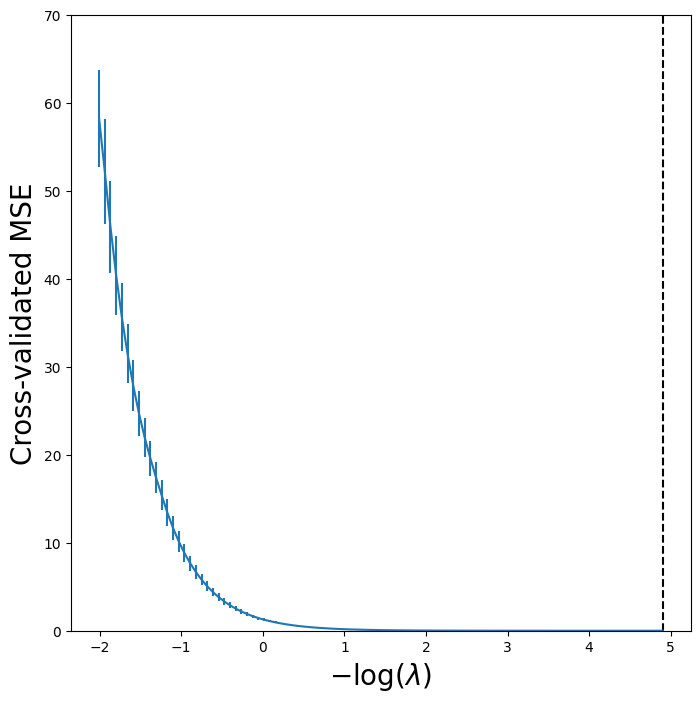

In [104]:
lassoCV_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1))
ax.axvline(-np.log(tuned_lasso.alpha_), c="k", ls="--")
ax.set_ylim([0, 70])
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-validated MSE", fontsize=20)


In [107]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
linreg = LinearRegression()
pipe = Pipeline([("pca", pca), ("linreg", linreg)])
pipe.fit(X, y)
pipe.named_steps["linreg"].coef_

array([[0.10878525, 0.07558789]])

In [108]:
pipe = Pipeline([("scaler", scaler),
                 ("pca", pca),
                 ("linreg", linreg)])
pipe.fit(X, y)
pipe.named_steps["linreg"].coef_

array([[2.18531496, 0.8920772 ]])

In [109]:
param_grid = dict(pca__n_components=range(1,20))
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(0.0, 15.0)

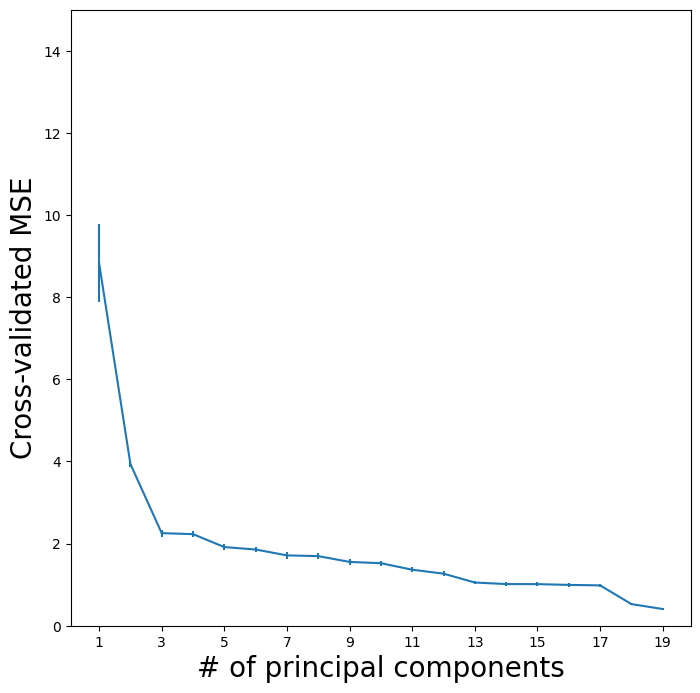

In [113]:
pcr_fig, ax = plt.subplots(figsize=(8,8))
n_comp = param_grid["pca__n_components"]
ax.errorbar(n_comp, -grid.cv_results_["mean_test_score"],
            grid.cv_results_["std_test_score"])
ax.set_ylabel("Cross-validated MSE", fontsize=20)
ax.set_xlabel("# of principal components", fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([0,15])

In [114]:
pipe.named_steps["pca"].explained_variance_ratio_

array([0.34050987, 0.1907049 ])

In [115]:
# Partial least squares
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X, y)

PLSRegression()

In [116]:
param_grid = dict(n_components=range(1,20))
grid = GridSearchCV(pls, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(X, y)

GridSearchCV(cv=5, estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(0.0, 15.0)

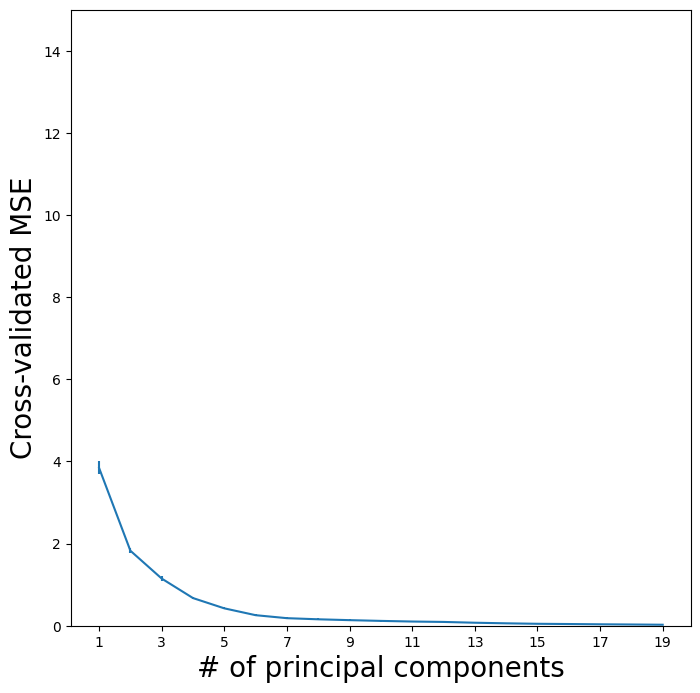

In [117]:
pls_fig, ax = plt.subplots(figsize=(8,8))
n_comp = param_grid["n_components"]
ax.errorbar(n_comp,
            -grid.cv_results_["mean_test_score"],
            grid.cv_results_["std_test_score"])
ax.set_ylabel("Cross-validated MSE", fontsize=20)
ax.set_xlabel("# of principal components", fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([0,15])

In [122]:
# PCR is constructed using principal component analysis,
# while PLS constructs latent vaiables that capture the maximum
# covariance between the predcitors and response. Latent variables
# are constructed simulataneously for X and y. Each latent variable
# is a linear combination of the original features

array([[ 0.38138455,  0.44694391,  0.49534022,  0.04797807,  0.01259933,
         0.41644815,  0.18016806,  0.53968755,  0.37761076,  0.52735981,
         0.60303609,  0.01731599, -0.005557  ,  0.14654241,  0.52517552,
         0.4574067 ,  0.44542851,  0.00413261,  0.33766045,  0.09598463,
         0.251172  ,  0.21280273,  0.1914224 ,  0.44864467,  0.55143359,
         0.90700839,  0.73266692,  0.53755848,  0.7425966 ,  0.47323214,
         0.66557935]])